# Preamble

In [180]:
using Pkg
Pkg.activate("../env")
include("./parallelPlanner.jl")
include("./GA.jl")
include("./parallelCGA.jl")
include("./plottingUtils.jl")
include("demo_utils.jl")

  Activating environment at `~/git-clones/Y4-Diss/code/julia/env/Project.toml`


show_file (generic function with 3 methods)

# Applications of Genetic Algorithms on Fully autonomous road networks

I am researching the applications of Genetic Algorithms (GAs) on fully autonomous road networks, specifically, *(theoretical)* autonomous motorways

- Self driving cars are becoming more and more prevelant. 
- Population & car ownership is increasing 
- Roads are becoming more congested with a 78% increase in motor traffic since 1993
- All currently implemented systems are _selfish_, i.e. each vehicle is only concerned with itself and minimising the travel time of their occupants.
- By taking a higher level view of vehicle routing we can potentially reduce the average travel time, saving more time in total, increasing efficiency of existing road networks.
- Much of the current research focuses on semi-autonomous road networks, i.e. roads where there is a combination of autonomous and human-driven vehicles

## Genetic Algorithms

Genetic algorithms are a nature-inspired optimisation technique that mimic the process of evolution on populations of candidate solutions.

Their abstract composition is represented nicely by my code: 

```julia
𝓕 = curry(curry(Fitness, road), other_routes) # Curry fitness function with road as this is a static attribute of the function. Allows for nicer piping of data.
P = generatePopulation(n, start, goal, road)
map(p -> p.fitness = p |> 𝓕, P) # Calculate fitness for initial population, map 𝓕 over all Individuals
while n_gens > 0 && length(P) > 0# Replace with stopping criteria
    P = (P
        |> P -> selection(P, method=selection_method)  # Selection operator
        |> simple_crossover |> new_pop -> append!(P, new_pop)  # Crossover operator & Add newly generated individuals to population
        |> P -> mutation!(P,road,method=mutation_method) # apply mutation operator
        |> P -> begin map(p -> p.fitness = p |> 𝓕, P); P end # recalculate fitness of population after mutation
        |> P -> map(repair, P)  # attempt repair of invalid solutions
        |> P -> sort(P, by=p -> p.fitness) # Sort my fitness
        |> P -> filter(isValid, P) # remove invalid solutions
        |> P -> P[1:minimum([n,length(P)])] # take top n
    )
    n_gens -= 1
end
```

There are 4 main components of a GA

1. Selection
2. Crossover
3. Mutation 
4. Fitness 

All of which are to some extent domain-specific but the _most_ domain-specific is the `Fitness` operator.

This operation assigns a relative fitness to each individual in a population, this is used to rank the solutions and encourage growth towards the optimal solution.

### Fitness of Candidate routes

Fitness of a route as encoded as a Bezier Curve is abstractly quite simple. 

It is tied to it's length.

The shorter the route, the better the solution.

The length of a Bezier curve is not a simple calculation but can be approximated well 


This is the basis for my fitness function. However it must be augmented to guide the system to optimal solutions. 

Extensions include:

- Penalising routes which pass through "_infeasible_" space, i.e. intersect obstacles or exit the road space.
- Penalising routes which pass too closely to such infeasible regions

This gives the following fitness function for my single-agent planner:

\begin{equation}
           F(x) = \texttt{curve_length}(x) + \alpha \cdot \texttt{infeasible_dist}(x) + \beta \cdot \texttt{close_prox_dist}(x) 
\end{equation}

Where $\alpha$ and $\beta$ are paramters which require tuning.

### Benefits of GAs

Many of the alternative approaches to the problem of vehicle routing are what are known as _black box_ approaches. I.e. methods such as Neural Networks in which a model is produced that is very difficult to reason about and predict.

A model trained on a poorly selected set of training data can make wrong decisions that cannot be predicted ahead of time.

GAs on the other hand are an transparent approach, in which every stage is human readable. 



# Single agent planning

In my previous demo I showed my working single-agent planner. 

It was able to:

- Avoid obstacles of circular and rectangular shape
- Avoid leaving the predefined road-space

In [147]:
b1(x) = 0
b2(x) = 10

start_point = Point(0, 5)
goal_point = Point(15, 8)

o1 = Circle(1, Point(15, 5))
o2 = Circle(1.2, Point(2.5, 7))
o3 = Circle(0.8, Point(7, 6))
o4 = Circle(0.8, Point(12, 2))
l = 20
road = Road(b1, b2, [o1, o2, o3, o4], l)

road_plt = draw_road(road, 0, l)
scatter!(
    road_plt,
    [(start_point.x, start_point.y), (goal_point.x, goal_point.y)],
);


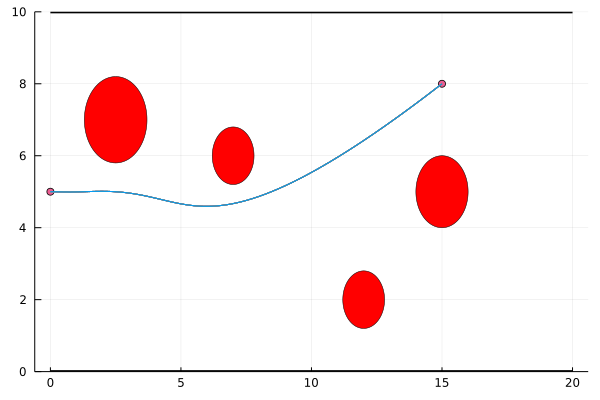

In [148]:
P = GA(
    start_point,
    goal_point,
    road,
    n_gens = 4,
    n = 10,
    selection_method = ranked,
)
plotGeneration!(road_plt, P)


Below you can see an example of the learning process over the course of 100 generations for a simliar road space problem

![foo](https://sambarrett.online/Y4-Diss/100gens-3.gif)

## Evaluation 

I have started to collect data to evaluate my single agent planner. It will not be the focus of my evaluation as it has become a subsection of my larger project.  I indend to collect similar results varying the genetic operators and parameter values used. I will also vary the number and size of any obstacles.

[Fitness landscape of single agent planning](../images/single-agent-result.html)

# Multi-agent planning




The general idea of my cooperative planner is quite simple. 

Given a set of $n$ start-goal pairs, plan a route for $start[i]\rightarrow goal[i], \forall i \in [1,n]$ Where the $i^{th}$ agent plans around the previous $i-1$ routes.

```julia
function PCGA(
    starts::Array{Point},
    goals::Array{Point},
    road::Road,
    n_gens::Real=1, n::Real=10,
    selection_method::SelectionMethod, mutation_method::MutationMethod
    )
    
    current_plans = SharedArray{SVector{12,Float64}}(length(starts))
    ret::Array{Individual} = []
    tasks::Array = []
    c = 1
    for (start, goal) in zip(starts, goals)       
        append!(tasks,
                [Threads.@spawn PCGA(start,goal,road,current_plans,i=deepcopy(c),
                    n_gens=n_gens,n=n, selection_method=selection_method,
                    mutation_method=mutation_method)])
        c = c + 1 
    end
    for task in tasks
        append!(ret, fetch(task))
    end
    
    ret
end
```

A key factor of this approach is making sure the routes do not collide. 

## Intersections & collisions

How do I differentiate between path intersection (legal) and route collision (illegal)? 

I make an assumption that all agents are travelling at the same constant speed.

The routes are defined as Bezier Curves and as such the position along the route at any point $t$ is given by $B(t)$, I can therefore say that if $\exists t_1,t_2 \in [0,1] $ s.t. $B_1(t_1) =B_2(t_2)$ then routes $B_1$ and $B_2$ intersect at some point. 

Going a step further I can say that $B_1$ and $B_2$ **collide** if $\texttt{curveLength}(B_1(t_1)) - \texttt{curveLength}(B_2(t_2)) < \varepsilon$. Or that if the distance from their relative start positions to the point of intersection is below a threshold, the routes collide.

Solving this equation however, is not trivial and as such the common approach to finding intersections between two Bezier curves is to approximate the answer via recursive subdivision, still a very computationally expensive procedure.


At one point this process alone resulted in a $\approx 50\times$ slowdown! To tackle this issue, I parallelised my `bezInt` function so that it can take advantage of the 16 cores in my system. 

I also implemented various heuristics to speedup the process.




These include:

- Implementing the logic that if no points in a random sample along a curve lie inside the bounded box of another curve, and vice virsa, they (likely) cannot intersect and deeper checking can be skipped. This is seen in the following code:



Initally, I did not have the random sample. instead checking each point in the convex hulls, However this failed to detect the intersection in the edge case below $\downarrow$


In [4]:
B1 = [Point(0,0),Point(1.5,3.6),Point(3,0)]
B2 = [Point(0,3),Point(1.5,-2),Point(3,3)]
plt = plot_curve(B1,100)
plot_control_points!(plt,B1)
plot_curve!(plt,2,B2,100)
plot!(plt,[B1[1].x,B1[2].x],[B1[1].y,B1[2].y],st=:line,linecolor=:black)
plot!(plt,[B1[1].x,B1[3].x],[B1[1].y,B1[3].y],st=:line,linecolor=:black)
plot!(plt,[B1[3].x,B1[2].x],[B1[3].y,B1[2].y],st=:line,linecolor=:black)

plot!(plt,[B2[1].x,B2[2].x],[B2[1].y,B2[2].y],st=:line,linecolor=:black)
plot!(plt,[B2[1].x,B2[3].x],[B2[1].y,B2[3].y],st=:line,linecolor=:black)
plot!(plt,[B2[3].x,B2[2].x],[B2[3].y,B2[2].y],st=:line,linecolor=:black)

plot_control_points!(plt,B2)

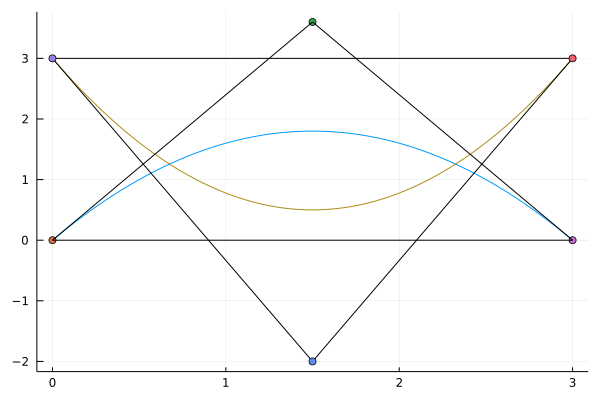

In [5]:
plt

This is as although the curves clearly intersect, none of the points in their convex hulls lie in the space defined by the convex hull of the other curve




- I also instituted a recursion depth limit, some edge cases will subdivide the curve until each section is infinitesimally small and slow the process down
- Another time-saving measure I implemented was to maintain a dictionary of previously checked curve pairs. As I realised that for each pair $(B_1,B_2)$ when calculating the fitness of $B_1$ this pair is tested and when calculating the fitness of $B_2$ the pair is tested again. By implementing this measure I in some cases halve the number of checks I have to do.

In [149]:
b1(x) = 0
b2(x) = 12
l = 20
obstacles = [ ]
road = Road(b1, b2, obstacles, l)
road_plt = draw_road(road, 0, l);
global CACHE=true

true

In [150]:
starts = [Point(0, 5), Point(0, 8), Point(0, 6)]

goals = [Point(20, 8), Point(18, 3), Point(15, 5)]

n=6 # size of population
ng=2 # number of generations


P = PCGA(
    starts,
    goals,
    road,
    n_gens = ng,
    n = n,
    selection_method = ranked,
    mutation_method = gaussian,
)



┌ Warning: Exiting early, within 10% of straight line fitness
└ @ Main /home/sam/git-clones/Y4-Diss/code/julia/src/parallelCGA.jl:123
┌ Warning: Exiting early, within 10% of straight line fitness
└ @ Main /home/sam/git-clones/Y4-Diss/code/julia/src/parallelCGA.jl:123
┌ Warning: Exiting early, within 10% of straight line fitness
└ @ Main /home/sam/git-clones/Y4-Diss/code/julia/src/parallelCGA.jl:123


3-element Vector{Individual}:
 Individual(Phenotype(Point(0, 5), Point[Point(0, 5), Point(20, 8)], Point(20, 8)), 20.223748416156685)
 Individual(Phenotype(Point(0, 8), Point[Point(0, 8), Point(18, 3)], Point(18, 3)), 18.681541692269406)
 Individual(Phenotype(Point(0, 6), Point[Point(0, 6), Point(15, 5)], Point(15, 5)), 15.033296378372908)

I implemented a simple heuristic to enable the procedure to exit early, skipping any remaining generations if the fitness of the current best solution is within 10% of that of a straight line.

┌ Info: Saved animation to 
│   fn = /home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif
└ @ Plots /home/sam/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/home/sam/git-clones/Y4-Diss/code/julia/src/anim1.gif")
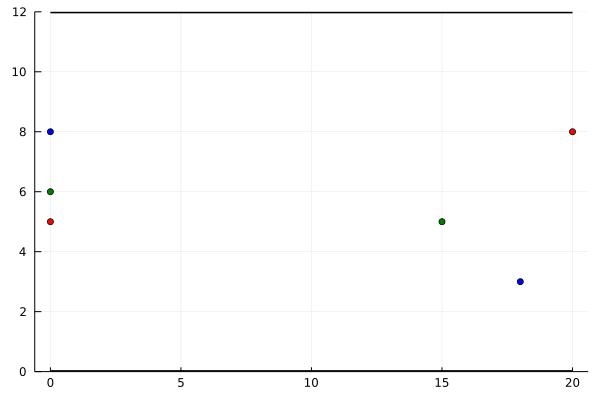

In [151]:
plot_generation_gif(road,P)

In [158]:
collisionDetection(i1,i2) = collisionDetection(i1.phenotype.genotype, i2.phenotype.genotype)
any_collisions = collisionDetection(P[1],P[2]) || collisionDetection(P[1],P[3]) ||  collisionDetection(P[3],P[2])

false

## Evaluation

I am also intending to collect data varying genetic operators, parameter values as well as the number of obstacles and agents being planned for.

[Fitness landscape for multi-agent planning](../images/multi-agent-result.html)

This system can work for any $n$ number of agents although the system does become slower as there are exponentially more collision detections that must be made each generation.

An example for 12 randomly generated start-goal pairs can be seen:



![12 agents](https://sambarrett.online/Y4-Diss/12-agents.gif)

It is quite confusing and highlights an issue with my current implementation: the system has no method for slowing down/stopping agents to avoid collisions, instead plannning increasingly strange routes to get around it.

# Macro level route planning

Planning routes for vehicles is not just about routing a single set of vehicles through a set section of road. There is a bigger picture: a interconnected network of roads with vehicles traversing multiple different sections of road to get from $A \rightarrow B$ 

To implement this, I used a graphing library in which I can attach metadata to edges. The metadata I chose to attach was the `Road` structure I have been using for my micro-level planning. I can then perform Dijkstra's algorithm on this road network, weighting each edge with the `Road.length` attribute. 

Each agent can then be assigned a series of road segments it must traverse in order to reach it's global goal position.

In [10]:
desired_paths = [
    (1,4),
    (4,2),
    (1,4),
    (3,5)
]

4-element Vector{Tuple{Int64, Int64}}:
 (1, 4)
 (4, 2)
 (1, 4)
 (3, 5)

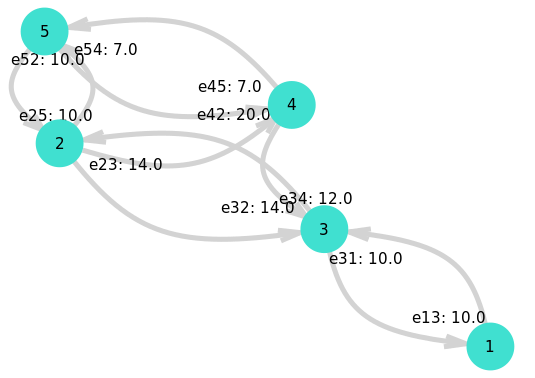

In [174]:
include("demoRoadNetwork.jl")

In [ ]:
plans = planRoutes(desired_paths, rn);

┌ Warning: too many control points? Individual(Phenotype(Point(0, 6.5), Point[Point(0, 6.5), Point(0.7777777777777778, 6.7), Point(1.5555555555555556, 6.7), Point(2.4333333333333336, 6.9), Point(3.511111111111111, 6.9), Point(3.988888888888889, 6.9), Point(4.666666666666667, 7.0), Point(5.044444444444444, 6.8), Point(6.022222222222222, 7.0), Point(6.3, 6.8), Point(10, 7.0)], Point(10, 7.0)), 10.164555007820672)
└ @ Main /home/sam/git-clones/Y4-Diss/code/julia/src/GAUtils.jl:45
┌ Warning: Exiting early, within 10% of straight line fitness
└ @ Main /home/sam/git-clones/Y4-Diss/code/julia/src/parallelCGA.jl:123
┌ Warning: Exiting early, within 10% of straight line fitness
└ @ Main /home/sam/git-clones/Y4-Diss/code/julia/src/parallelCGA.jl:123
┌ Warning: too many control points? Individual(Phenotype(Point(0, 0.5), Point[Point(0, 0.5), Point(0.55, 0.7), Point(1.8, 0.49999999999999994), Point(2.35, 0.7), Point(3.5, 0.49999999999999994), Point(4.55, 0.29999999999999993), Point(5.6999999999999

Here I employ Dijkstra's algorithm to plan the toplevel _macro_ routes from $A\rightarrow B$ which produces the list of _intersections_ the route must pass through. Each edge or _road_ is weighted by its length but this could _easily_ be extended to be more dynamic and take into account congestion etc.

In [13]:
start = plans[1][1].phenotype.genotype[1]
goal = plans[1][1].phenotype.genotype[end]
(plans[1][1].fitness / √((start.x - goal.x)^2 +(start.y - goal.y)^2))<1.1


LoadError: UndefVarError: plans not defined

When planning these routes it is necessary to be aware of which agents are on the same road at the same time. 

Just becuase the path for agent $A$ is $1 \rightarrow 2 \rightarrow 3$ and $B$ is $4\rightarrow 2 \rightarrow 3$ doesn't necessarily mean that when planning we must consider both. 

However if $len(e12) \leq len(e23)$ then they **will** share the edge $e23$ and the planning must take this into account. Otherwise if $len(e12) > len(e23)$ then agent $B$ will have left the edge before $A$ enters.

In [14]:
plts = plot_road_network(plans, rn, desired_paths)

LoadError: UndefVarError: plans not defined

In [15]:
    macroPaths = map(i -> macroPath(rn, i[1],i[2]), desired_paths)
    pathGroups = getPathGroups(rn,desired_paths, macroPaths)


LoadError: MethodError: no method matching getPathGroups(::Graphs.Graph{Int64, Any}, ::Vector{Tuple{Int64, Int64}}, ::Vector{Vector{Int64}})
[0mClosest candidates are:
[0m  getPathGroups(::Graphs.GenericGraph, ::Any) at /home/sam/git-clones/Y4-Diss/code/julia/src/parallelPlanner.jl:4

Two of these routes should be staggered compared with the other as the _enter_ the road later. This has proved difficult to visualise 

Edge $e25$ from the graph will have these routes passing through it:

In [16]:
plts[1]

LoadError: UndefVarError: plts not defined

## Edge $e32$ 

In [17]:
plts[2]

LoadError: UndefVarError: plts not defined

## Edge $e52$ 

In [18]:
plts[3]

LoadError: UndefVarError: plts not defined

## Edge $e54$ 

In [19]:
plts[4]

LoadError: UndefVarError: plts not defined

## Edge $e13$ 

In [20]:
plts[5]

LoadError: UndefVarError: plts not defined

## Edge $e45$

In [21]:
plts[6]

LoadError: UndefVarError: plts not defined

# Going forward

Sadly, I am running out of time. But given more time to research this I would look at all of the following areas:

1. Incorporating a velocity-time profile for each agent in the learning process, allowing for the assumption of constant velocity to be broken
2. Reduce abstraction, incorporate vehicle size, focus more on smoothness and viability of routes in real-life.
3. Think about more smartly setting start/ end points of vehciles in the macro-level planning 
4. Further increase planning speed through more heuristics or even GPU parallelism/ distributed computation
5. **Tune parameters more precisely**
6. **Implement more genetic operators and better assess which lend themselves best to the task**

# Any Questions?